In [1]:
import numpy as np
import cv2
import os
from tqdm import tqdm
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pickle
from glob import glob 
import imgaug as ia
from imgaug import augmenters as iaa
from shapely.geometry import Polygon

repository = "/home/michel/Documents/CardDetection/GenCardDataset/"
os.chdir(repository)

In [2]:
cardW = 60
cardH = 114
cornerXmin=3*4
cornerXmax=9*4
cornerYmin=3*4
cornerYmax=19*4
imgW=720
imgH=720

# We convert the measures from mm to pixels: multiply by an arbitrary factor 'zoom'
zoom=4
cardW*=zoom
cardH*=zoom
decalX=int((imgW-cardW)*0.5)
decalY=int((imgH-cardH)*0.5)

x1 = cornerXmin
y1 = cornerYmin
x2 = cornerXmax
y2 = cornerYmax

#Define the corners points of each 4 corners
corner1 = [[cornerXmin, cornerYmin],[cornerXmax, cornerYmin],[cornerXmin, cornerYmax],[cornerXmax, cornerYmax]]
corner2 = [[cardW-cornerXmax, cornerYmin],[cardW-cornerXmin, cornerYmin],[cardW-cornerXmax, cornerYmax],[cardW-cornerXmin, cornerYmax]]
corner3 = [[cornerXmin, cardH-cornerYmax],[cornerXmax, cardH-cornerYmax],[cornerXmin,cardH-cornerYmin],[cornerXmax,cardH-cornerYmin]]
corner4 = [[cardW-cornerXmax, cardH-cornerYmax],[cardW-cornerXmin, cardH-cornerYmax],[cardW-cornerXmax,cardH-cornerYmin],[cardW-cornerXmin,cardH-cornerYmin]]


## Imports

## Useful functions and classes

In [3]:

def display_img(img,polygons=[],channels="bgr",size=9):
    """
        Function to display an inline image, and draw optional polygons (bounding boxes, convex hulls) on it.
        Use the param 'channels' to specify the order of the channels ("bgr" for an image coming from OpenCV world)
    """
    if not isinstance(polygons,list):
        polygons=[polygons]    
    if channels=="bgr": # bgr (cv2 image)
        nb_channels=img.shape[2]
        if nb_channels==4:
            img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGBA)
        else:
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)    
    fig,ax=plt.subplots(figsize=(size,size))
    ax.set_facecolor((0,0,0))
    ax.imshow(img)
    for polygon in polygons:
        # An polygon has either shape (n,2), 
        # either (n,1,2) if it is a cv2 contour (like convex hull).
        # In the latter case, reshape in (n,2)
        if len(polygon.shape)==3:
            polygon=polygon.reshape(-1,2)
        patch=patches.Polygon(polygon,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(patch)

def give_me_filename(dirname, suffixes, prefix=""):
    """
        Function that returns a filename or a list of filenames in directory 'dirname'
        that does not exist yet. If 'suffixes' is a list, one filename per suffix in 'suffixes':
        filename = dirname + "/" + prefix + random number + "." + suffix
        Same random number for all the file name
        Ex: 
        > give_me_filename("dir","jpg", prefix="prefix")
        'dir/prefix408290659.jpg'
        > give_me_filename("dir",["jpg","xml"])
        ['dir/877739594.jpg', 'dir/877739594.xml']        
    """
    if not isinstance(suffixes, list):
        suffixes=[suffixes]
    
    suffixes=[p if p[0]=='.' else '.'+p for p in suffixes]
          
    while True:
        bname="%09d"%random.randint(0,999999999)
        fnames=[]
        for suffix in suffixes:
            fname=os.path.join(dirname,prefix+bname+suffix)
            if not os.path.isfile(fname):
                fnames.append(fname)
                
        if len(fnames) == len(suffixes): break
    
    if len(fnames)==1:
        return fnames[0]
    else:
        return fnames
    
class Backgrounds():
    def __init__(self,backgrounds_pck_fn):
        self._images=pickle.load(open(backgrounds_pck_fn,'rb'))
        self._nb_images=len(self._images)
        print("Nb of images loaded :", self._nb_images)
    def get_random(self, display=False):
        bg=self._images[random.randint(0,self._nb_images-1)]
        if display: plt.imshow(bg)
        return bg
    


class Cards():
    def __init__(self,cards_pck_fn):
        self._cards=pickle.load(open(cards_pck_fn,'rb'))
        # self._cards is a dictionary where keys are card names (ex:'Kc') and values are lists of (img,hullHL,hullLR) 
        self._nb_cards_by_value={k:len(self._cards[k]) for k in self._cards}
        print("Nb of cards loaded per name :", self._nb_cards_by_value)
        
    def get_random(self, card_name=None, display=False):
        if card_name is None:
            card_name= random.choice(list(self._cards.keys()))
        card = self._cards[card_name][random.randint(0,self._nb_cards_by_value[card_name]-1)]
        if display:
            if display: display_img(card,"rgb")
        return card[0],card_name


# Define global variables

In [4]:
data_dir="data_input" # Directory that will contain all kinds of data (the data we download and the data we generate)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

    
card_suits=['c']
card_values=['1','2','3','4','5','6','7','8','9']

# Pickle file containing the background images from the DTD
backgrounds_pck_fn=data_dir+"/backgrounds.pck"

# Pickle file containing the card images
cards_pck_fn=data_dir+"/cards.pck"

# Load cards pickle
cards = Cards(cards_pck_fn=cards_pck_fn)

# Load backgrounds pickle
backgrounds = Backgrounds(backgrounds_pck_fn=backgrounds_pck_fn)

Nb of cards loaded per name : {'1c': 15, '2c': 15, '3c': 15, '4c': 15, '5c': 15, '6c': 15, '7c': 15, '8c': 15, '9c': 15}
Nb of images loaded : 600


# Augmentation!

## Define useful functions

In [5]:
def corner_to_kps(corner, decalX=decalX, decalY=decalY):
    """
    Transform corner array into imgaug.keypoints centered on the image
    """
    kps=[ia.Keypoint(x=p[0]+decalX,y=p[1]+decalY) for p in corner]
    kps=ia.KeypointsOnImage(kps, shape=(imgH,imgW,3))
    return kps

    rect = patches.Rectangle((x1, y1),x2-x1,y2-y1,linewidth=1,edgecolor='b',facecolor='none')
    return rect

kps1 = corner_to_kps(corner1)
kps2 = corner_to_kps(corner2)
kps3 = corner_to_kps(corner3)
kps4 = corner_to_kps(corner4)
list_kps = [kps1, kps2, kps3, kps4]


def kps_rectangle(kps):
    """
    Given 4 kps, return the values of the 4 lines of a box
    """
    x1 = min([keypoints.x for keypoints in kps.keypoints])
    x2 = max([keypoints.x for keypoints in kps.keypoints])
    y1 = min([keypoints.y for keypoints in kps.keypoints])
    y2 = max([keypoints.y for keypoints in kps.keypoints])
    return x1,x2,y1,y2

def superposed(img, list_kps):
    """
    If img cover any kps in list_kps, remove this kps
    """
    e = 0
    list_rem = []
    for kps in list_kps:
        x1,x2,y1,y2 = kps_rectangle(kps)
        if img[int((y1+e)):int((y2-e)),int((x1+e)):int((x2-e)),:].any():
            list_rem.append(kps)
    for kps in list_rem:
        list_kps.remove(kps)
    
    return list_kps

class BBA:  # Bounding box + annotations
    def __init__(self,x1,x2,y1,y2,classname):      
        self.x1=int(round(x1))
        self.y1=int(round(y1))
        self.x2=int(round(x2))
        self.y2=int(round(y2))
        self.classname=classname


def create_image(transf):      
    """
    Create an image composed of 2 images from cards and 1 background  from background
    using the imgaug transformation transf
    
    returns image array, bba (bounding box + annotatons) and list of kps for both cards
    
    """

    im1,card_val1=cards.get_random()
    img1=np.zeros((imgH,imgW,4),dtype=np.uint8)
    img1[decalY:decalY+cardH,decalX:decalX+cardW,:]= im1
    seq = transf.to_deterministic()
    im1 = seq.augment_images([img1])[0]
    list_kps_aug_1 = []
    [list_kps_aug_1.append(seq.augment_keypoints([kps])[0]) for kps in list_kps]

    im2,card_val2=cards.get_random()
    img2=np.zeros((imgH,imgW,4),dtype=np.uint8)
    img2[decalY:decalY+cardH,decalX:decalX+cardW,:]= im2
    seq = transf.to_deterministic()
    im2 = seq.augment_images([img2])[0]
    list_kps_aug_2 = []
    [list_kps_aug_2.append(seq.augment_keypoints([kps])[0]) for kps in list_kps]

    # Remove im2 boxes behind im1
    list_kps_aug_1 = superposed(im2, list_kps_aug_1)

    bba = []
    for kps in list_kps_aug_1:
        xmin,xmax,ymin,ymax = kps_rectangle(kps)
        bba.append(BBA(xmin,xmax,ymin,ymax,card_val1))

    for kps in list_kps_aug_2:
        xmin,xmax,ymin,ymax = kps_rectangle(kps)
        bba.append(BBA(xmin,xmax,ymin,ymax,card_val2))

    bg=backgrounds.get_random()
    bg=scaleBg.augment_image(bg)
    mask1=im1[:,:,3]
    mask1=np.stack([mask1]*3,-1)
    final=np.where(mask1,im1[:,:,0:3],bg)
    mask2=im2[:,:,3]
    mask2=np.stack([mask2]*3,-1)
    final=np.where(mask2,im2[:,:,0:3],final)
    return final,bba, list_kps_aug_1, list_kps_aug_2

## Check if everything is ok

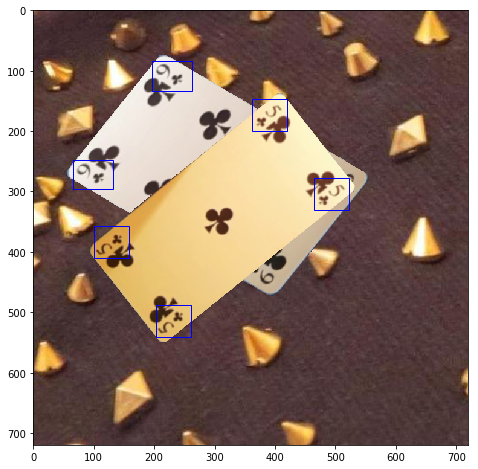

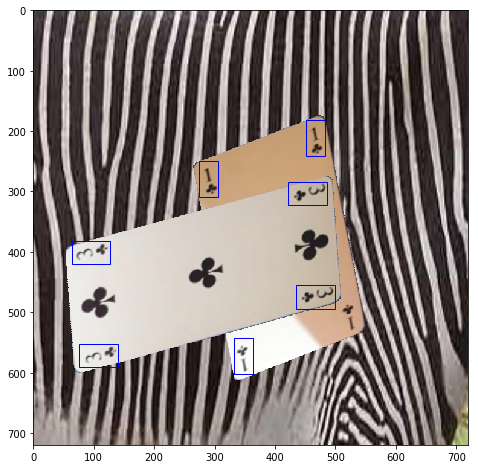

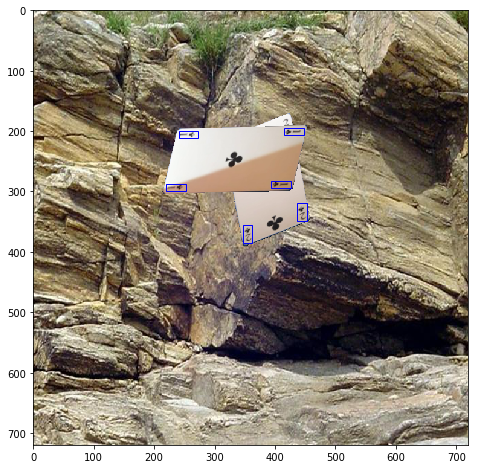

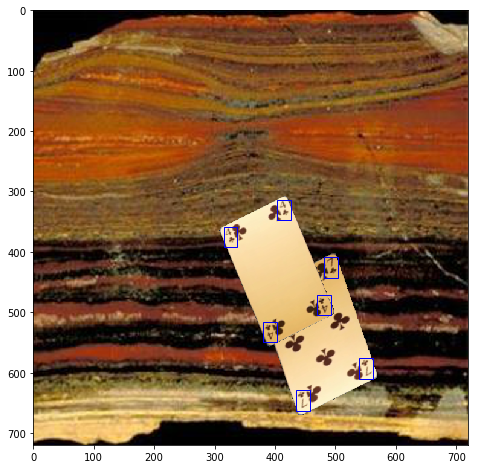

In [6]:
# Define transformations using imgaug 

transform_1card = iaa.Sequential([
    iaa.AverageBlur([0,3]),
    iaa.Affine(scale=[0.85,1.15]),
    iaa.Affine(rotate=(-180,180)),
    iaa.Affine(translate_percent={"x":(-0.15,0.15),"y":(-0.15,0.15)}),
    iaa.Affine(shear=[0,20])  
])

transform_2card = iaa.Sequential([
    iaa.AverageBlur([0,3]),
    iaa.Affine(scale=[0.45,0.6]),
    iaa.Affine(rotate=(-180,180)),
    iaa.Affine(translate_percent={"x":(-0.35,0.35),"y":(-0.35,0.35)}),
    iaa.Affine(shear=[0,20])  
])


scaleBg=iaa.Scale({"height": imgH, "width": imgW})

# Check if everything is OK
for i in range(2):
    final,bba, list_kps_aug_1, list_kps_aug_2 = create_image(transform_1card)
    fig,ax=plt.subplots(1,figsize=(8,8))
    ax.imshow(final)
    for kps in list_kps_aug_1:
        x1,x2,y1,y2 = kps_rectangle(kps)
        rect=patches.Rectangle((x1, y1),x2-x1,y2-y1,linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)
    for kps in list_kps_aug_2:
        x1,x2,y1,y2 = kps_rectangle(kps)
        rect=patches.Rectangle((x1, y1),x2-x1,y2-y1,linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)
        
for i in range(2):
    final,bba, list_kps_aug_1, list_kps_aug_2 = create_image(transform_2card)
    fig,ax=plt.subplots(1,figsize=(8,8))
    ax.imshow(final)
    for kps in list_kps_aug_1:
        x1,x2,y1,y2 = kps_rectangle(kps)
        rect=patches.Rectangle((x1, y1),x2-x1,y2-y1,linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)
    for kps in list_kps_aug_2:
        x1,x2,y1,y2 = kps_rectangle(kps)
        rect=patches.Rectangle((x1, y1),x2-x1,y2-y1,linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect)

## Define xml functions

For each image we have to create a .xml file following PASCAL VOC format

We create `nb_cards_to_generate` pairs .xml and .jpg and save it in the folder `save_dir`

In [8]:
xml_body_1="""<annotation>
        <folder>FOLDER</folder>
        <filename>{FILENAME}</filename>
        <path>{PATH}</path>
        <source>
                <database>Unknown</database>
        </source>
        <size>
                <width>{WIDTH}</width>
                <height>{HEIGHT}</height>
                <depth>3</depth>
        </size>
"""
xml_object=""" <object>
                <name>{CLASS}</name>
                <pose>Unspecified</pose>
                <truncated>0</truncated>
                <difficult>0</difficult>
                <bndbox>
                        <xmin>{XMIN}</xmin>
                        <ymin>{YMIN}</ymin>
                        <xmax>{XMAX}</xmax>
                        <ymax>{YMAX}</ymax>
                </bndbox>
        </object>
"""
xml_body_2="""</annotation>        
"""

def create_voc_xml(xml_file, img_file,listbba,display=False):
    with open(xml_file,"w") as f:
        f.write(xml_body_1.format(**{'FILENAME':os.path.basename(img_file), 'PATH':img_file,'WIDTH':imgW,'HEIGHT':imgH}))
        for bba in listbba:            
            f.write(xml_object.format(**{'CLASS':bba.classname,'XMIN':bba.x1,'YMIN':bba.y1,'XMAX':bba.x2,'YMAX':bba.y2}))
        f.write(xml_body_2)
        if display: print("New xml",xml_file)

def write_files(final,save_dir,listbba,display=False):
    jpg_fn, xml_fn=give_me_filename(save_dir, ["jpg","xml"])
    plt.imsave(jpg_fn,final)
    if display: print("New image saved in",jpg_fn)
    create_voc_xml(xml_fn,jpg_fn, listbba,display=display)

transform_1card = iaa.Sequential([
    iaa.AverageBlur([0,3]),
    iaa.Affine(scale=[0.85,1.15]),
    iaa.Affine(rotate=(-180,180)),
    iaa.Affine(translate_percent={"x":(-0.15,0.15),"y":(-0.15,0.15)}),
    iaa.Affine(shear=[0,20])  
])

transform_2card = iaa.Sequential([
    iaa.AverageBlur([0,3]),
    iaa.Affine(scale=[0.45,0.6]),
    iaa.Affine(rotate=(-180,180)),
    iaa.Affine(translate_percent={"x":(-0.35,0.35),"y":(-0.35,0.35)}),
    iaa.Affine(shear=[0,20])  
])

transforms = [transform_1card, transform_2card]

save_dir = "data_output/train"
nb_cards_to_generate = 9

for i in tqdm(range(nb_cards_to_generate)):
    transf = random.choice(transforms)
    final,bba,a,b = create_image(transf)
    write_files(final,save_dir,bba)

100%|██████████| 9/9 [00:01<00:00,  8.09it/s]


# Generate records

In order to use tensorflow we need a .csv which contains the name of each image and all the coordinates of every box.

In addition, we need a .record file which contains all the images and boxes

In [17]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

name_csv = 'data_output/9cards.csv'

image_path = os.path.join(os.getcwd(), save_dir)
xml_df = xml_to_csv(image_path)
xml_df.to_csv(name_csv, index=None)
print('Successfully converted xml to csv.')

Successfully converted xml to csv.


Generate records is less directly, 
we have to modify the file `generate_records.py` and make two changes.

1. Change the folder where the images are located
2. Add the names of all the classes you use

Then we change in the following cell, `csv_inpt`, `image_dir` and select an `output_path`

In [18]:
repository = "/home/michel/Documents/CardDetection/GenCardDataset/"
os.chdir(repository)
!python generate_tfrecord.py \
    --csv_input=data_output/9cards.csv \
    --image_dir=data_input/train \
    --output_path=data_output/9cards.record

Successfully created the TFRecords: /home/michel/Documents/CardDetection/GenCardDataset/data_output/9cards.record
